<a href="https://colab.research.google.com/github/Miniapple8888/Food101Classifier/blob/main/Food_CV_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food CV Classifier

## Dataset
We will be using the [Food 101 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html).

🎯 Goal: Classify 101 food.

Most of the training techniques and functions are taken from https://www.learnpytorch.io

How to improve:
- change epochs (training time)
- change # layers / # hidden units
- change amount of data (more data -> more info, but more compute time)
- change learning rate
- change data augmentation
- choose different model architecture
- experiment with transfer learning
- overfitting?
  - learning rate decay
  - dropout layers
  - regularization


# Installation / Setup

In [ ]:
# import pytorch & other useful libraries
import os, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
from PIL import Image
from pathlib import Path

try:
  from torchinfo import summary
except:
  print(f"Importing torchinfo")
  !pip install torchinfo
  from torchinfo import summary

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
writer = SummaryWriter()

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [3]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# helper function to make reproducible experiment
def set_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
set_seeds()

# Preprocessing

- Split train/test
- Dataloader to use transforms

In [5]:
resize_shape = 64
# transforms
data_transforms = transforms.Compose([
    transforms.Resize(size=(resize_shape, resize_shape)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [6]:
# import food101 dataset
data_path = '/data'
train_dir = data_path + '/train'
test_dir = data_path + '/test'
img_path = Path(data_path)

train_data = datasets.Food101(root=train_dir,
                              transform=data_transforms,
                              split="train",
                              download=True)

test_data = datasets.Food101(root=test_dir,
                             transform=data_transforms,
                             split="test",
                             download=True)

train_data, test_data

100%|██████████| 4996278331/4996278331 [04:42<00:00, 17676625.57it/s]


Extracting /data/train/food-101.tar.gz to /data/train


100%|██████████| 4996278331/4996278331 [04:47<00:00, 17360129.61it/s]


Extracting /data/test/food-101.tar.gz to /data/test


(Dataset Food101
     Number of datapoints: 75750
     Root location: /data/train
     split=train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset Food101
     Number of datapoints: 25250
     Root location: /data/test
     split=test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ))

In [7]:
# create dataloaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c45c193e8f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c45c193fd60>)

# Data Exploration

- Try displaying a random image

In [ ]:
def walk_through_dir(dir):
  for dir_path, dirnames, filenames in os.walk(dir):
    print(f"In {dir_path}, there is {len(dirnames)} directories & {len(filenames)}")

In [ ]:
walk_through_dir(data_path)

img path /data/train/food-101/images/ceviche/879248.jpg
img class ceviche
height 512
width 512


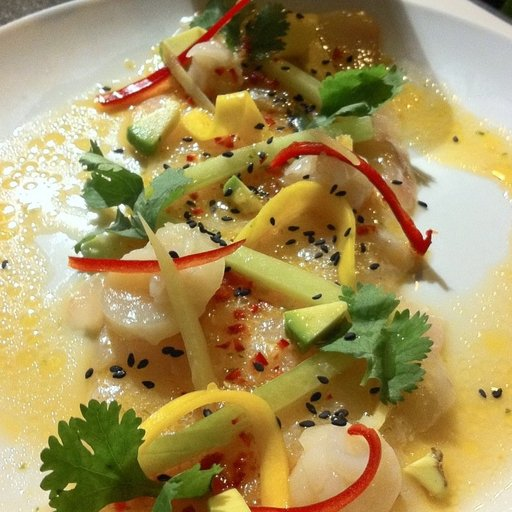

In [8]:
img_path = Path(data_path) / 'train' / 'food-101'
# img list
img_list = list(img_path.glob('*/*/*.jpg'))
# rand img
rand_img = random.choice(img_list)
img_class = rand_img.parent.stem
# display img
img = Image.open(rand_img)

print(f"img path {rand_img}")
print(f"img class {img_class}")
print(f"height {img.height}")
print(f"width {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

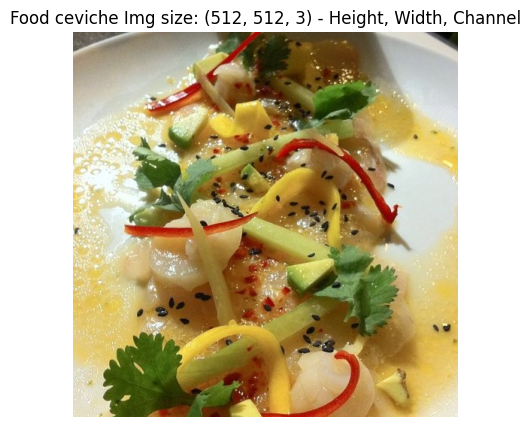

In [9]:
img_array = np.asarray(img)
plt.figure(figsize=(5,5))
plt.imshow(img_array)
plt.title(f"Food {img_class} Img size: {img_array.shape} - Height, Width, Channel")
plt.axis(False)

In [10]:
# train dataloader inside
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [11]:
res_img = data_transforms(img).unsqueeze(dim=0)
conv_layer = nn.Conv2d(3, 10, 3, 1)
relu1 = nn.ReLU()
conv_layer2 = nn.Conv2d(10, 10, 3, 1)
relu2 = nn.ReLU()
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
flatten = nn.Flatten()
linear = nn.Linear(in_features=10*13*13, out_features=len(train_data.classes))
block1 = maxpool(relu2(conv_layer2(relu1(conv_layer(res_img)))))
block2 = maxpool(relu2(conv_layer2(relu1(conv_layer2(block1)))))
flatten(block2).shape
linear(flatten(block2))

tensor([[-0.0049,  0.0035,  0.0394,  0.0050, -0.0034, -0.0251, -0.0056, -0.0218,
          0.0235,  0.0037, -0.0843, -0.0022,  0.0110, -0.0333,  0.0129,  0.0416,
         -0.0520,  0.0207, -0.0160,  0.0047, -0.0004,  0.0107, -0.0059,  0.0010,
          0.0006,  0.0024, -0.0382, -0.0236,  0.0049, -0.0124, -0.0099,  0.0104,
         -0.0025,  0.0032,  0.0186,  0.0122,  0.0109,  0.0211,  0.0358, -0.0003,
          0.0209,  0.0113, -0.0136, -0.0316,  0.0232, -0.0034, -0.0168, -0.0264,
         -0.0024, -0.0080,  0.0448,  0.0062, -0.0065,  0.0006, -0.0309,  0.0497,
          0.0095, -0.0176, -0.0245,  0.0232, -0.0122,  0.0391,  0.0034,  0.0030,
         -0.0225,  0.0159,  0.0106, -0.0259, -0.0086, -0.0358, -0.0102,  0.0036,
         -0.0017,  0.0243, -0.0286,  0.0047,  0.0317, -0.0187, -0.0437, -0.0087,
         -0.0221,  0.0163, -0.0093,  0.0300,  0.0363,  0.0267,  0.0195,  0.0179,
          0.0647,  0.0377, -0.0201,  0.0009, -0.0085, -0.0157, -0.0184, -0.0173,
          0.0215, -0.0101, -

# Model


In [12]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    return self.classifier(x)

In [13]:
input_shape = 3 # rgb
output_shape = len(train_data.classes)
# HYPERPARAMETER
hidden_units = 10

model_0 = TinyVGG(input_shape, output_shape, hidden_units)
model_0.to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=101, bias=True)
  )
)

# Load Pre-trained model (transfer learning)
We will use `EfficientNet_B0`

In [18]:
# to solve error with weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [19]:
# get transforms from pre-trained model
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [21]:
# get a summary of our model
summary(model=model_1,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [23]:
# freeze feature base layers
for param in model_1.features.parameters():
  param.requires_grad = False

In [24]:
# change classifier layer to appropriate output shape + target device
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # look at summary to find in_features
              out_features=output_shape,
              bias=True)
).to(device)

# ViT Architecture
Stands for [Vision Transformer](https://arxiv.org/pdf/2103.16107v3.pdf)

In [36]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [37]:
# MSA
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 attn_dropout:float=0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [38]:
# MLP layer
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [39]:
# transformer encoder: series of mla > mlp > mla > mlp > etc.
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        x =  self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [52]:
# Actual ViT model
class ViT(nn.Module):
  def __init__(self,
               img_size: int=224,
               in_channels: int=3,
               patch_size: int=16,
               num_transformer_layers: int=12,
               embedding_dim: int=768,
               mlp_size: int=3072,
               num_heads: int=12,
               attn_dropout: float=0.1,
               mlp_dropout: float=0.1,
               embedding_dropout: float=0.1,
               num_classes: int=1000):
    super().__init__()
    assert img_size % patch_size == 0, f"Image size {img_size} must be divisible by patch size {patch_size}"
    self.num_patches = int(img_size / patch_size)
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim), requires_grad=True)
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    self.trans_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    self.classifier = nn.Sequential(
      nn.LayerNorm(normalized_shape=embedding_dim),
      nn.Linear(in_features=embedding_dim, out_features=num_classes)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])
    return x

In [53]:
vit = ViT(num_classes=len(train_data.classes))
# summary of ViT model
summary(model=vit,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

# Loss / Optimizer

In [25]:
# accuracy fn
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [26]:
# HYPERPARAMETER
learning_rate = 0.1

# loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=learning_rate)

# Training

In [27]:
# helper method (timer)
from timeit import default_timer as timer

def print_train_time(start, end, device):
  total_time = end - start
  print(f"Train time on {device}: {total_time} seconds")
  return total_time

In [34]:
def train_step(model, dataloader, loss_fn, acc_fn, optimizer, device):
  train_loss, train_acc = 0, 0

  model.to(device)
  model.train()
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += acc_fn(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train Loss: {train_loss} | Train Acc: {train_acc}%")
  return train_loss, train_acc

def test_step(model, dataloader, loss_fn, acc_fn, device):
  model.to(device)
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc = 0,0
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model_0(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += acc_fn(test_pred, y)

    test_loss /= len(dataloader)
    train_acc /= len(dataloader)

    print(f"Test Loss: {test_loss} | Train Acc: {test_acc}%")
    return test_loss, test_acc

In [32]:
# import progress bar
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          loss_fn,
          acc_fn,
          optimizer: torch.optim,
          epochs: int=10,
          device: torch.device=device):
  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
  }
  timer_start = timer()

  for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch} -------------")
    train_loss, train_acc = train_step(model=model_0,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn,
                                        optimizer=optimizer,
                                        device=device)
    test_loss, test_acc = test_step(model=model_0,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    acc_fn=acc_fn,
                                    device=device)
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    timer_end = timer()
    total_train_time_model_0 = print_train_time(start=timer_start,
                                                end=timer_end,
                                                device=device)
    return results

In [33]:
# HYPERPARAMETER
epochs = 10

model_res = train(model=model_0,
                  loss_fn=loss_fn,
                  acc_fn=acc_fn,
                  optimizer=optimizer,
                  epochs=epochs)

model_res

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 -------------
Train Loss: 4.867188995661909 | Train Acc: 0.0%


AttributeError: module 'torch' has no attribute 'inference_model'

# Evaluation

- plot eval metrics
- plot loss curves
- plot rand img prediction

In [ ]:
# evaluate model
def eval_model(model, dataloader, loss_fn, acc_fn, device):
  model.to(device)
  model.eval()
  with torch.inference_mode():
    loss, acc = 0, 0
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += acc_fn(y_pred, y)
    loss /= len(dataloader)
    acc /= len(dataloader)
    print(f"Loss: {loss} | Accuracy: {acc}%")
    return { "model_name": model.__class__.__name__,
             "model_loss": loss,
             "model_acc": acc}

In [ ]:
model0_results = eval_model(model_0, test_dataloader, loss_fn, acc_fn, device)
model0_results

In [ ]:
# plot model loss curves
def plot_model_loss_curves(data):
  epoch_count = len(results["train_loss"])
  train_loss_values, test_loss_values = data["train_loss"], data["test_loss"]
  train_acc_values, test_acc_values = data["train_acc"], data["train_acc"]

  plt.subplot(1, 2, 1)
  plt.plot(epoch_count, train_loss_values, label="Train loss")
  plt.plot(epoch_count, test_loss_values, label="Test loss")
  plt.title("Loss")
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epoch_count, train_acc_values, label="Train acc")
  plt.plot(epoch_count, test_acc_values, label="Test acc")
  plt.title("Accuracy")
  plt.ylabel("Accuracy (%)")
  plt.xlabel("Epochs")
  plt.legend()

In [ ]:
plot_model_loss_curves(results)

In [ ]:
# make predictions for bunch of images
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [ ]:
from typing import List, Tuple

# make prediction for a single image and display it
def pred_and_plot_img(model: nn.Module,
                      img_path: str,
                      class_names: List[str],
                      img_size: Tuple[int, int] = (224, 224),
                      transform: torch.transforms = None,
                      device: torch.device = device):
  img = Image.open(img_path)
  if transform is not None:
    img_transform = transform(img)
  else:
    img_transform = transforms.Compose([
                          transforms.Resize(img_size),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225]),
                      ])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    transf_img = img_transform(img).unsqueeze(dim=0)
    img_pred = model(transf_img.to(device))
    img_pred_probs = torch.softmax(img_pred, dim=1)
    img_pred_label = torch.argmax(img_pred_probs, dim=1)
    # plot img now
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Pred: {class_names[img_pred_label]} | Prob {img_pred_probs}%")
    plt.axis(False)

In [ ]:
pred_and_plot_img(model_0, img_path, train_data.classes, img_size, data_transforms, device)

# Saving Model

In [ ]:
def save_model(model: nn.Module,
               model_name: str,
               model_save_path: str):
  MODEL_PATH = Path(model_save_path)
  MODEL_PATH.mkdir(parents=True,
                  exist_ok=True
  )

  MODEL_NAME = model_name + '.pth'
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

  # Save model state dict
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
save_model(model_0, "food101_model10", '/models')

# Load Model

In [ ]:
loaded_model_2 = BaseLineModel(input_shape=1,
                                    hidden_units=10,
                                    output_shape=len(dataset))

# Load in saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to current device
loaded_model_2 = loaded_model_2.to(device)